# 🔍 Model Interpretability
## Student Dropout Prediction Project

**Goal:** Understand *why* the model makes specific predictions using SHAP (SHapley Additive exPlanations). This is crucial for identifying key drivers of student dropout.

In [21]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import sys
import os
import importlib
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.append('..')
import config
importlib.reload(config)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load Data and Model

In [22]:
try:
    # Load Data
    train_df = pd.read_csv(config.TRAIN_DATA_PATH)
    test_df = pd.read_csv(config.TEST_DATA_PATH)
    
    X_train = train_df.drop(columns=['Target'])
    y_train = train_df['Target']
    X_test = test_df.drop(columns=['Target'])
    y_test = test_df['Target']
    
    # Load Model
    model_path = config.MODEL_DIR / "best_model.pkl"
    model = joblib.load(model_path)
    
    print(f"✓ Data and Model loaded successfully")
    print(f"Model type: {type(model).__name__}")
    
except FileNotFoundError as e:
    print(f"❌ Error: {e}")


target_encoder = joblib.load(config.MODEL_DIR / "target_encoder.pkl")

✓ Data and Model loaded successfully
Model type: RandomForestClassifier


## 2. Initialize SHAP Explainer
We use `TreeExplainer` because our best model (Random Forest or XGBoost) is tree-based. This is faster and more exact than KernelExplainer.

In [23]:
import numpy as np
import shap
import pandas as pd

# Get SHAP values for Dropout class (class 0)
if isinstance(shap_values, list):
    sv_for_ranking = shap_values[0]
else:
    sv_for_ranking = shap_values

print(f"SHAP values shape: {sv_for_ranking.shape}")
print(f"X_test_sample shape: {X_test_sample.shape}")

# Calculate mean absolute SHAP value for each feature
mean_abs_shap = np.abs(sv_for_ranking).mean(axis=0)

print(f"mean_abs_shap shape: {mean_abs_shap.shape}")
print(f"mean_abs_shap type: {type(mean_abs_shap)}")

# Create a Series for easier handling
feature_importance = pd.Series(mean_abs_shap, index=X_test_sample.columns)
feature_importance = feature_importance.sort_values(ascending=False)

print("\nTop 5 features:")
print(feature_importance.head())

# Get the top feature name
top_feature_name = feature_importance.index[0]
print(f"\nTop feature for Dropout prediction: {top_feature_name}")

# Plot dependence
shap.dependence_plot(top_feature_name, sv_for_ranking, X_test_sample, 
                     interaction_index='auto')

# Save the plot
import matplotlib.pyplot as plt
plt.savefig('../images/shap_dependence.png', dpi=300, bbox_inches='tight')
print("✓ Dependence plot saved!")

SHAP values shape: (500, 15, 3)
X_test_sample shape: (500, 15)
mean_abs_shap shape: (15, 3)
mean_abs_shap type: <class 'numpy.ndarray'>


ValueError: Data must be 1-dimensional, got ndarray of shape (15, 3) instead

In [24]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

# Calculate shap values. This is what we will plot.
# We'll use a sample of the test set to speed up calculation if needed, 
# but for this dataset size, full test set might be okay.
# Let's use a sample of 500 for speed in demonstration.
X_test_sample = X_test.sample(n=500, random_state=config.RANDOM_STATE)
shap_values = explainer.shap_values(X_test_sample)

print("✓ SHAP values calculated")

# --- ROBUST SHAPE FIX ---
def fix_shap_shape(shap_vals, X):
    if isinstance(shap_vals, list):
        fixed_vals = []
        for i, sv in enumerate(shap_vals):
            if sv.shape[1] == X.shape[1] + 1:
                print(f"⚠️ Fixing shape for class {i}: removing last column (bias)")
                fixed_vals.append(sv[:, :-1])
            else:
                fixed_vals.append(sv)
        return fixed_vals
    else:
        if shap_vals.shape[1] == X.shape[1] + 1:
            print("⚠️ Fixing shape: removing last column (bias)")
            return shap_vals[:, :-1]
        return shap_vals

shap_values = fix_shap_shape(shap_values, X_test_sample)
print("✓ Shape check complete")

✓ SHAP values calculated
✓ Shape check complete


## 3. Global Feature Importance (Summary Plot)
This plot shows the most important features for the model. 
- **Y-axis:** Features ordered by importance.
- **X-axis:** SHAP value (impact on model output).
- **Color:** Feature value (Red = High, Blue = Low).

Plotting SHAP summary for: Dropout (Target=0)


<Figure size 1000x800 with 0 Axes>

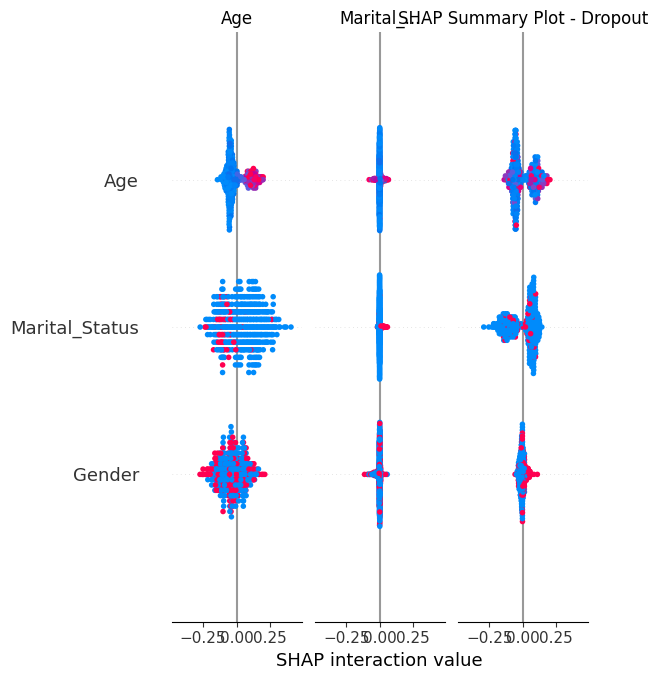

In [25]:
# Summary Plot for Class 0 (Dropout)
class_names = ['Dropout', 'Enrolled', 'Graduate'] # Assuming standard encoding 0, 1, 2

print(f"Plotting SHAP summary for: {class_names[0]} (Target=0)")
plt.figure(figsize=(10, 8))

# Handle list vs array for shap_values
sv_to_plot = shap_values[0] if isinstance(shap_values, list) else shap_values

# Double check shape before plotting
if sv_to_plot.shape[1] != X_test_sample.shape[1]:
    print(f"⚠️ Warning: Shape mismatch still detected! SHAP: {sv_to_plot.shape}, X: {X_test_sample.shape}")
    # Emergency fix
    if sv_to_plot.shape[1] == X_test_sample.shape[1] + 1:
        sv_to_plot = sv_to_plot[:, :-1]

shap.summary_plot(sv_to_plot, X_test_sample, plot_type="dot", show=False)
plt.title(f"SHAP Summary Plot - {class_names[0]}")
plt.show()

Plotting SHAP summary for: Graduate (Target=2)


<Figure size 1000x800 with 0 Axes>

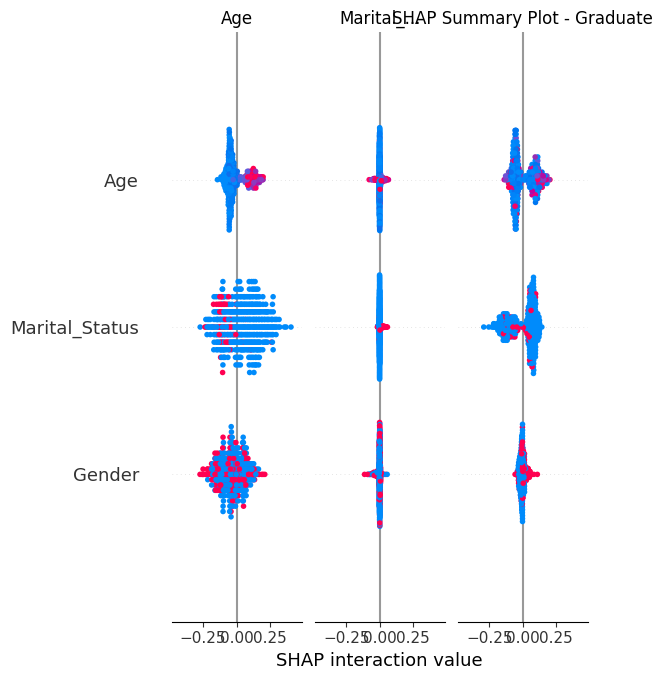

In [26]:
# Summary Plot for Class 2 (Graduate)
print(f"Plotting SHAP summary for: {class_names[2]} (Target=2)")
plt.figure(figsize=(10, 8))

sv_to_plot = shap_values[2] if isinstance(shap_values, list) else shap_values

# Emergency fix
if sv_to_plot.shape[1] == X_test_sample.shape[1] + 1:
    sv_to_plot = sv_to_plot[:, :-1]

shap.summary_plot(sv_to_plot, X_test_sample, plot_type="dot", show=False)
plt.title(f"SHAP Summary Plot - {class_names[2]}")
plt.show()

## 4. Feature Dependence Plot
Shows how a single feature affects the prediction, and how it interacts with another feature.

In [27]:
student_idx = 0
student_data = X_test_sample.iloc[student_idx]

print(f"Explaining prediction for student #{student_idx}")
print(f"Feature values:\n{student_data}")

# Get actual prediction
actual_prediction = model.predict(X_test_sample.iloc[[student_idx]])[0]
prediction_proba = model.predict_proba(X_test_sample.iloc[[student_idx]])[0]

print(f"\n🔮 Model Prediction: {target_encoder.classes_[actual_prediction]}")
print(f"Confidence Scores:")
for i, cls in enumerate(target_encoder.classes_):
    print(f"  {cls}: {prediction_proba[i]:.2%}")

# Generate force plot
import matplotlib.pyplot as plt

sv_local = shap_values[0][student_idx] if isinstance(shap_values, list) else shap_values[student_idx]
base_value = explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value

plt.figure(figsize=(16, 3))
shap.plots.force(base_value, sv_local, student_data, matplotlib=True, show=False)
plt.tight_layout()
plt.savefig('../images/shap_force_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Force plot saved to images/shap_force_plot.png")

Explaining prediction for student #0
Feature values:
Age                       -0.279319
Gender                     1.335802
Marital_Status            -0.291574
Course                    -0.936770
Mother_Qualification      -1.095706
Father_Qualification       0.589923
Previous_Qualification    -0.323240
Displaced                 -1.105752
Debtor                    -0.354457
Tuition_Fees_Up_To_Date   -2.537020
Scholarship_Holder        -0.559538
Unemployment_Rate         -1.506941
Inflation_Rate             1.006710
GDP                        0.136353
Admission_Grade           -0.042748
Name: 832, dtype: float64

🔮 Model Prediction: Dropout
Confidence Scores:
  Dropout: 86.20%
  Enrolled: 6.20%
  Graduate: 7.60%


TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

<Figure size 1600x300 with 0 Axes>

In [28]:
try:
    # Load Data
    train_df = pd.read_csv(config.TRAIN_DATA_PATH)
    test_df = pd.read_csv(config.TEST_DATA_PATH)
    
    X_train = train_df.drop(columns=['Target'])
    y_train = train_df['Target']
    X_test = test_df.drop(columns=['Target'])
    y_test = test_df['Target']
    
    # Load Model
    model_path = config.MODEL_DIR / "best_model.pkl"
    model = joblib.load(model_path)
    
    # Load Target Encoder ← ADD THIS LINE
    target_encoder = joblib.load(config.MODEL_DIR / "target_encoder.pkl")
    
    print(f"✓ Data and Model loaded successfully")
    print(f"Model type: {type(model).__name__}")
    print(f"Target classes: {target_encoder.classes_}")
    
except FileNotFoundError as e:
    print(f"❌ Error: {e}")

✓ Data and Model loaded successfully
Model type: RandomForestClassifier
Target classes: ['Dropout' 'Enrolled' 'Graduate']


## 5. Local Explanation (Force Plot)
Explain a *single* prediction. Why did the model predict Dropout/Graduate for this specific student?

# Select a specific student
student_idx = 0
student_data = X_test_sample.iloc[student_idx]

print(f"Explaining prediction for student #{student_idx}")
print(f"Feature values:\n{student_data}")

# Get actual prediction
actual_prediction = model.predict(X_test_sample.iloc[[student_idx]])[0]
prediction_proba = model.predict_proba(X_test_sample.iloc[[student_idx]])[0]

print(f"\n🔮 Model Prediction: {target_encoder.classes_[actual_prediction]}")
print(f"Confidence Scores:")
for i, cls in enumerate(target_encoder.classes_):
    print(f"  {cls}: {prediction_proba[i]:.2%}")

# Generate force plot
sv_local = shap_values[0][student_idx] if isinstance(shap_values, list) else shap_values[student_idx]
base_value = explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value

plt.figure(figsize=(16, 3))
shap.plots.force(base_value, sv_local, student_data, matplotlib=True, show=False)
plt.tight_layout()
plt.savefig('../images/shap_force_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Force plot saved to images/shap_force_plot.png")

In [29]:
# Select a specific student (e.g., the first one in our sample)
student_idx = 0
student_data = X_test_sample.iloc[student_idx]

print(f"Explaining prediction for student #{student_idx}")
print(f"Feature values:\n{student_data}")

# Get SHAP values for this student
sv_local = shap_values[0][student_idx] if isinstance(shap_values, list) else shap_values[student_idx]
base_value = explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value

# Generate matplotlib-based force plot (compatible with SHAP v0.20+)
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 3))
shap.plots.force(base_value, sv_local, student_data, matplotlib=True, show=False)
plt.tight_layout()
plt.savefig('../images/shap_force_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Force plot generated and saved to images/shap_force_plot.png")

Explaining prediction for student #0
Feature values:
Age                       -0.279319
Gender                     1.335802
Marital_Status            -0.291574
Course                    -0.936770
Mother_Qualification      -1.095706
Father_Qualification       0.589923
Previous_Qualification    -0.323240
Displaced                 -1.105752
Debtor                    -0.354457
Tuition_Fees_Up_To_Date   -2.537020
Scholarship_Holder        -0.559538
Unemployment_Rate         -1.506941
Inflation_Rate             1.006710
GDP                        0.136353
Admission_Grade           -0.042748
Name: 832, dtype: float64


TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

<Figure size 1600x300 with 0 Axes>

## 6. Bar Plot of Feature Importance
A simpler view of global importance.

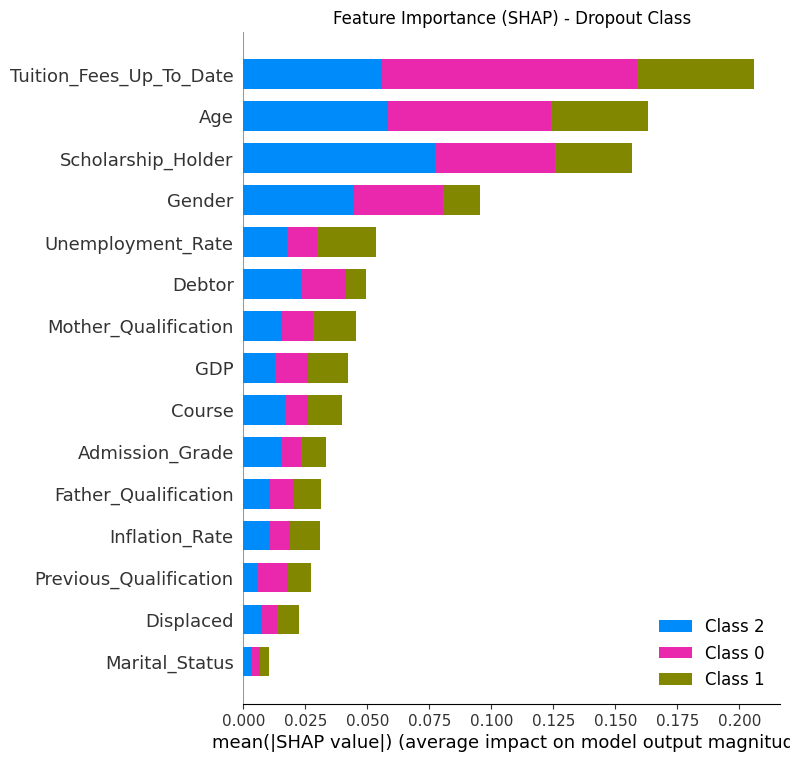

In [30]:
plt.figure(figsize=(10, 6))
sv_to_plot = shap_values[0] if isinstance(shap_values, list) else shap_values

# Emergency fix
if sv_to_plot.shape[1] == X_test_sample.shape[1] + 1:
    sv_to_plot = sv_to_plot[:, :-1]

shap.summary_plot(sv_to_plot, X_test_sample, plot_type="bar", show=False)
plt.title("Feature Importance (SHAP) - Dropout Class")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../images/shap_summary.png'

<Figure size 1000x800 with 0 Axes>

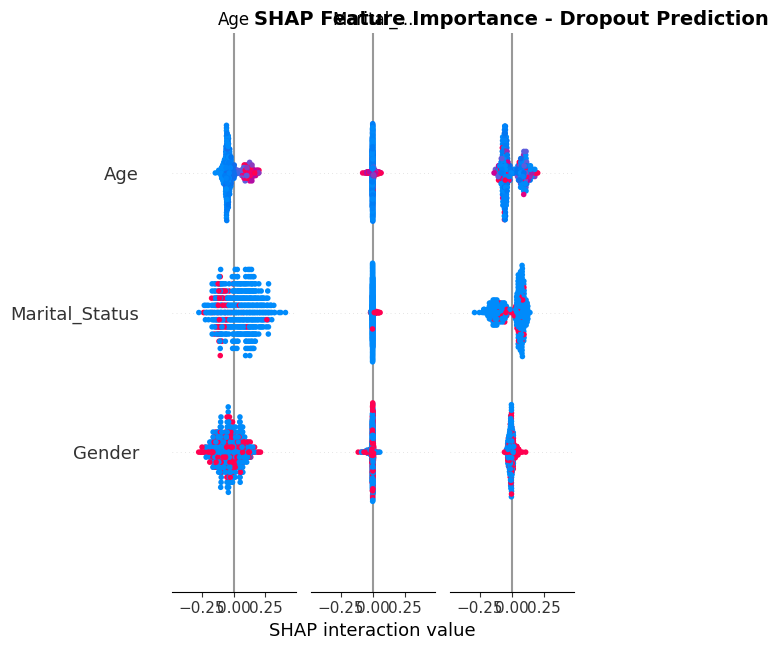

In [31]:
import matplotlib.pyplot as plt
import shap

sv_to_plot = shap_values[0] if isinstance(shap_values, list) else shap_values

plt.figure(figsize=(10, 8))
shap.summary_plot(sv_to_plot, X_test_sample, plot_type="dot", show=False)
plt.title('SHAP Feature Importance - Dropout Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../images/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()